In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import cho_factor, cho_solve
import time

### Import des données

In [4]:
#Import des données et sélection des features qui nous interresse
df = pd.read_csv("day.csv")
colonnes_features = ["mnth","weathersit","temp", "atemp", "hum","windspeed"]
X = df[colonnes_features].to_numpy()
Y = df[["cnt"]].to_numpy()
Xtilde = np.hstack((np.ones((731, 1)), X))
Xtilde[:,0] = Xtilde[:,0]/12 
Xtilde[:,1] = Xtilde[:,1]/4 

### Fonctions utiles

In [5]:
def prox_l1(lmb, tau, beta):
    """ Renvoie le prox pour la norme L1
    Paramètres
    ----------
    gamma: float
        Pas de descente
    lambd: float
        Paramètre de régularisation
    beta: numpy.ndarray
        Point d'évaluation
        
    Returns
    -------
    y: numpy.ndarray
        Point of argmin
    """
    return np.sign(beta) * np.maximum(np.abs(beta) - lmb*tau, 0.0)

def grad_f1(beta, Xtilde, Y):
    """Renvoie le gradient de la fonction f_1 = || Y- Xtilde beta||^2
    Paramètres
    ----------
    beta: numpy.ndarray
        Point d'évaluation
    Xtilde: numpy.ndarray
        Features de la database
    Y: numpy.ndarray
        Variable cnt dans notre database
    Return
    ------
    y: numpy.ndarray
        Gradient de f_1(beta)
    """
    return ((-Xtilde.T)@(Y-Xtilde@beta))


def prox_f1(beta, tau, Xtilde, Y):
    """Renvoie le prox de la fonction tau*f_1 = tau*0.5*|| Y- Xtilde beta||^2
    Paramètres
    ----------
    beta: numpy.ndarray
        Point d'évaluation
    tau: float
        pas de descente
    Xtilde: numpy.ndarray
        Features de la database
    Y: numpy.ndarray
        Variable cnt dans notre database
    Return
    ------
    y: numpy.ndarray
        Gradient de f_1(beta)
    """
    n_features = Xtilde.shape[1]
    A = Xtilde.T @ Xtilde*tau + np.eye(n_features)
    B = Xtilde.T @ Y *tau + beta

    # Résolution stable via Cholesky
    c, lower = cho_factor(A)
    x = cho_solve((c, lower), B)
    return x
    #return ( tau*(Xtilde.T)@(Xtilde@beta-Y) -beta )

# Algorithme FISTA

In [18]:
def algoFISTA(x0, Y, Xtilde, tau, max_iter, lmb=0.0, tol=1e-5, a=4.0):
    """
    Algorithme FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)

    Paramètres
    ----------
    x0 : np.ndarray
        État initial du vecteur de paramètres.
    Y : np.ndarray
        Données observées (ex. : comptage de vélos).
    Xtilde : np.ndarray
        Matrice de données (ou design matrix).
    tau : float
        Pas de descente (taux d’apprentissage).
    max_iter : int
        Nombre maximal d’itérations autorisé.
    lmb : float, optionnel
        Paramètre de régularisation L1 (par défaut 0.0).
    tol : float, optionnel
        Tolérance de convergence : l’algorithme s’arrête si 
        ||x_{n+1} - x_n|| < tol (par défaut 1e-5).
    a : float, optionnel
        Paramètre du schéma FISTA (par défaut 4.0).

    Retours
    -------
    xn : np.ndarray
        Tableau des itérés successifs (forme : [n_iter + 1, K]).
        Le dernier élément est une approximation du minimum.
    err : np.ndarray
        Suite des erreurs entre itérations successives.
    niter : int
        Nombre d’itérations réellement effectuées avant arrêt.
    """

    #Initialisation
    niter = 0
    xn = [x0]
    vn = [x0]
    err = []

    #Pré-calcul des coefficients FISTA
    t = (1 / a) * np.arange(max_iter) + (1 - 1 / a)
    alpha = (t[:-1] - 1) / t[1:]

    #Première itération
    grad = grad_f1(x0, Xtilde, Y)
    x1 = prox_l1(lmb, tau, x0 - tau * grad)
    v1 = x1 + alpha[0] * (x1 - x0)

    xn.append(x1)
    vn.append(v1)
    err.append(np.linalg.norm(x1 - x0))

    #Boucle principale
    while (err[-1] > tol) and (niter + 2 < max_iter):
        # Vérification de stabilité numérique
        if (np.any(np.isnan(xn[-1]))) or (np.any(np.isinf(xn[-1]))) or (np.linalg.norm(xn[-1]) > 1e50):
            #print(f"Valeurs instables détectées à l'itération {niter}, arrêt prématuré.")
            niter = max_iter
            break
        niter += 1
        grad = grad_f1(vn[-1], Xtilde, Y)
        x_next = prox_l1(lmb, tau, vn[-1] - tau * grad)
        diff = np.linalg.norm(x_next - xn[-1])
        v_next = x_next + alpha[niter] * (x_next - xn[-1])
        
        err.append(diff)
        xn.append(x_next)
        vn.append(v_next)

    return np.array(xn), np.array(err), niter

## Différentes Illustrations pour cet algorithme

In [5]:
#Paramètres
x0 = np.zeros((7,1))
tau = 10**(-5)
lmb = np.sqrt(np.log(6)/732)
max_iter = 100_000
tol = 1e-5

### Convergence composante par composante

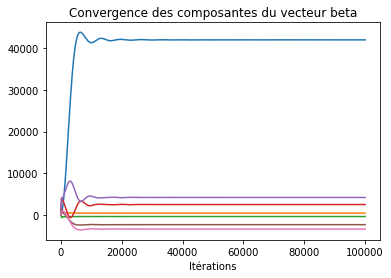

In [6]:
xn = algoFISTA(x0, Y, Xtilde, tau, max_iter, lmb, tol, a=4.0)[0]

#Illustration
plt.figure()
for i in range(7):
    plt.plot(range(0,len(xn)),xn[:,i])
plt.title("Convergence des composantes du vecteur beta")
plt.xlabel("Itérations")
plt.show()

### Regression linéaire

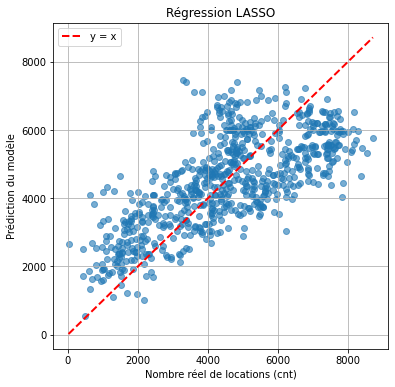


MSE : 1879370.49
R² : 0.499


In [7]:
xn = algoFISTA(x0, Y, Xtilde, tau, max_iter, lmb, tol, a=4)[0]
beta_hat = xn[-1]
Y_pred = Xtilde @ beta_hat

#Illustration scatter
plt.figure(figsize=(6,6))
plt.scatter(Y, Y_pred, alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='y = x')
plt.xlabel("Nombre réel de locations (cnt)")
plt.ylabel("Prédiction du modèle")
plt.legend()
plt.title("Régression LASSO")
plt.grid(True)
plt.show()

#Evaluation
mse = np.mean((Y - Y_pred)**2)
r2 = 1 - np.sum((Y - Y_pred)**2) / np.sum((Y - Y.mean())**2)
print(f"\nMSE : {mse:.2f}")
print(f"R² : {r2:.3f}")

### Recherche du meilleur pas algorithmiquement

Le paramètre tau qui minimise le temps de sortie est : 0.0002979798


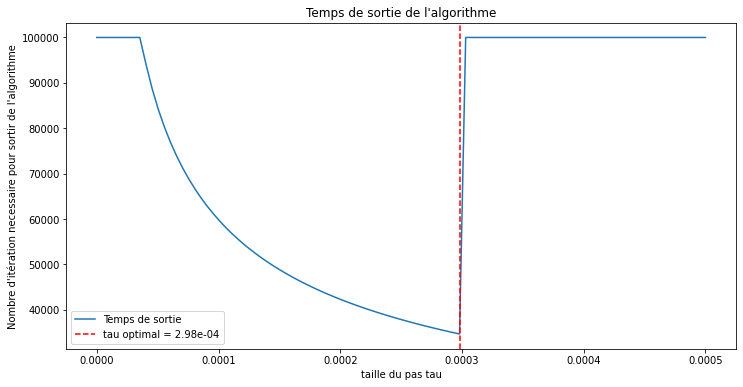

In [8]:
#Paramètres
Nsim = 100
tau_test = np.linspace(0.5*10**(-3),0.5*10**(-11),Nsim)
exit = [algoFISTA(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol, a=4)[2] for j in range(len(tau_test))]

#Optimum
tau_opti_FISTA = tau_test[np.argmin(exit)]
print("Le paramètre tau qui minimise le temps de sortie est :",tau_opti_FISTA)

#Illustration
plt.figure(figsize=(12, 6))
plt.title("Temps de sortie de l'algorithme")
plt.xlabel("taille du pas tau")
plt.ylabel("Nombre d'itération necessaire pour sortir de l'algorithme")
plt.plot(tau_test,exit,label=f'Temps de sortie')
plt.axvline(x=tau_opti_FISTA, color='red', linestyle='--', label=f'tau optimal = {tau_opti_FISTA:.2e}')
plt.legend()
plt.show()


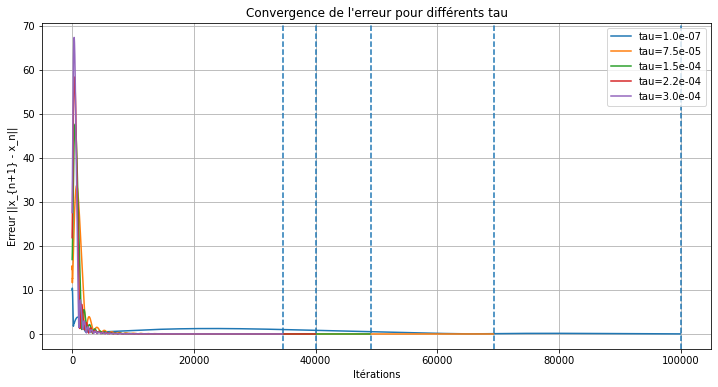

In [20]:
#Conséquence sur les erreurs successives
plt.figure(figsize=(12,6))
for tau in list(np.linspace(10**(-7),tau_opti_FISTA,5)):
    _, err, exit = algoFISTA(x0, Y, Xtilde, tau, max_iter=100000, lmb=lmb, tol=tol, a=4)
    plt.plot(err[100:], label=f'tau={tau:.1e}')
    plt.axvline(x=exit,linestyle='--')
#plt.yscale('log')
plt.xlabel('Itérations')
plt.ylabel('Erreur ||x_{n+1} - x_n||')
plt.title('Convergence de l\'erreur pour différents tau')
plt.legend()
plt.grid(True, which='both')
plt.show()

# Algorithme PEACEMAN-RACHFORD

In [7]:
def algoPR(x0, Y, Xtilde, tau, max_iter, lmb=0, tol=1e-5):
    """
    Algorithme de Peaceman-Rachford.

    Paramètres
    ----------
    x0 : np.ndarray
        Point initial.
    Y : np.ndarray
        Données observées.
    Xtilde : np.ndarray
        Matrice de données.
    tau : float
        Pas de descente.
    max_iter : int
        Nombre maximal d’itérations.
    lmb : float, optionnel
        Paramètre de régularisation L1.
    tol : float, optionnel
        Tolérance pour le critère d’arrêt (par défaut 1e-5).

    Retours
    -------
    yn : np.ndarray
        Suite des variables duales (après multiplication par tau).
    err : np.ndarray
        Erreurs successives ||y_{n+1} - y_n||.
    niter : int
        Nombre d’itérations effectuées.
    """

    # Initialisation
    niter = 0
    xn = [x0]
    yn = [prox_f1(x0, tau, Xtilde, Y)]
    err = []

    # Première itération
    x1 = 2 * prox_l1(lmb, tau, 2 * yn[0] - xn[0]) - 2 * yn[0] + xn[0]
    y1 = prox_f1(x1,tau, Xtilde, Y)

    xn.append(x1)
    yn.append(y1)
    err.append(np.linalg.norm(yn[1] - yn[0]))

    # Boucle principale
    while err[-1] > tol and niter + 3 < max_iter:
        niter += 1
        x_next = 2 * prox_l1(lmb, tau, 2 * yn[niter] - xn[niter]) - 2 * yn[niter] + xn[niter]
        y_next = prox_f1(x_next,tau, Xtilde, Y)

        xn.append(x_next)
        yn.append(y_next)
        err.append(np.linalg.norm(yn[-1] - yn[-2]))

    return np.array(xn), np.array(yn), np.array(err), niter
    

## Différentes illustrations

In [10]:
#Paramètres
x0 = np.ones((7,1))
tau = 10**(-2)
lmb = np.sqrt(np.log(6)/732)
max_iter = 100_000
tol = 1e-5

(8168, 7, 1)
[[1761.58504458]
 [3462.38337905]
 [3762.76200293]
 [3829.16934514]
 [3817.82080415]
 [3819.32363859]
 [3791.88510353]
 [3785.39124153]
 [3754.50117568]
 [3743.82038906]
 [3711.37924133]
 [3697.89012549]
 [3664.86040544]
 [3649.44441926]
 [3616.40579366]]


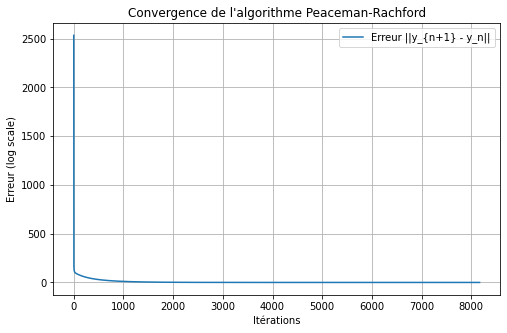

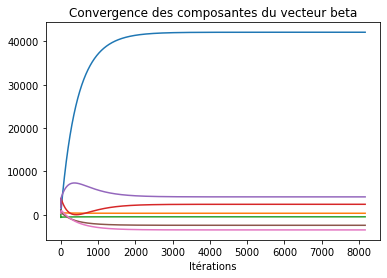

In [11]:
tau_test = 1 / (np.linalg.norm(Xtilde, ord=2) ** 2)
xn, yn, err, niter = algoPR(x0, Y, Xtilde, tau, max_iter, lmb, tol)
print(np.shape(yn))
print(yn[0:15,3])

# Plot convergence
plt.figure(figsize=(8,5))
plt.plot(err, label='Erreur ||y_{n+1} - y_n||')
plt.xlabel('Itérations')
plt.ylabel('Erreur (log scale)')
plt.title("Convergence de l'algorithme Peaceman-Rachford")
plt.legend()
plt.grid(True)
plt.show()

#Illustration
plt.figure()
for i in range(7):
    plt.plot(range(0,len(yn)),yn[:,i])
plt.title("Convergence des composantes du vecteur beta")
plt.xlabel("Itérations")
plt.show()

[899.0827784958958]


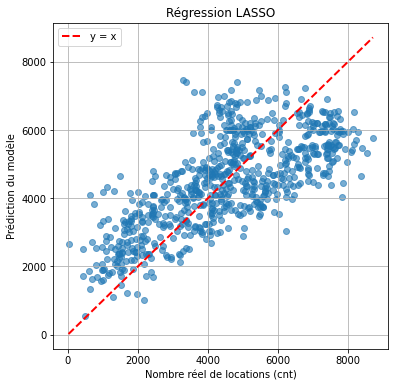


MSE : 1879372.34
R² : 0.499


In [76]:
_, yn, _, _ = algoPR(x0, Y, Xtilde, tau_opti, max_iter, lmb, tol)
beta_hat = yn[-1]
Y_pred = Xtilde @ beta_hat

#Illustration scatter
plt.figure(figsize=(6,6))
plt.scatter(Y, Y_pred, alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='y = x')
plt.xlabel("Nombre réel de locations (cnt)")
plt.ylabel("Prédiction du modèle")
plt.legend()
plt.title("Régression LASSO")
plt.grid(True)
plt.show()

#Evaluation
mse = np.mean((Y - Y_pred)**2)
r2 = 1 - np.sum((Y - Y_pred)**2) / np.sum((Y - Y.mean())**2)
print(f"\nMSE : {mse:.2f}")
print(f"R² : {r2:.3f}")

Le paramètre tau qui minimise le temps de sortie est : 0.05353535355858586


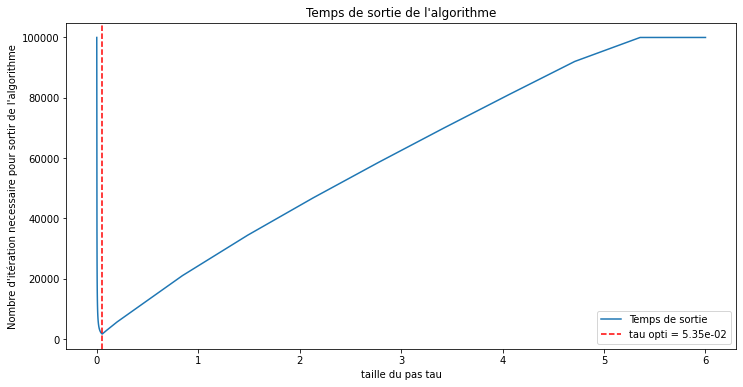

In [14]:
#Paramètres
Nsim = 100
tau_test = np.hstack((np.linspace(0.5*10**(-10),10**(-1),Nsim),np.linspace(10**(-1)+0.1,6,10)))
exit = [algoPR(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol)[3] for j in range(len(tau_test))]

#Optimum
tau_opti_PR = tau_test[np.argmin(exit)]
print("Le paramètre tau qui minimise le temps de sortie est :",tau_opti_PR)

#Illustration
plt.figure(figsize=(12, 6))
plt.title("Temps de sortie de l'algorithme")
plt.xlabel("taille du pas tau")
plt.ylabel("Nombre d'itération necessaire pour sortir de l'algorithme")
plt.plot(tau_test,exit,label=f'Temps de sortie')
plt.axvline(x=tau_opti_PR, color='red', linestyle='--', label=f'tau opti = {tau_opti_PR:.2e}')
plt.legend()
plt.show()


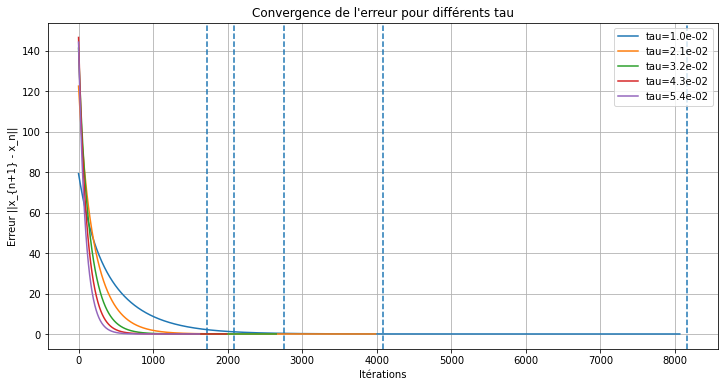

In [98]:
#Conséquence sur les erreurs successives
plt.figure(figsize=(12,6))
for tau in list(np.linspace(10**(-2),tau_opti,5)):
    _, _, err, exit = algoPR(x0, Y, Xtilde, tau, max_iter=100000, lmb=lmb, tol=tol)
    plt.plot(err[100:], label=f'tau={tau:.1e}')
    plt.axvline(x=exit,linestyle='--')
#plt.yscale('log')
plt.xlabel('Itérations')
plt.ylabel('Erreur ||x_{n+1} - x_n||')
plt.title('Convergence de l\'erreur pour différents tau')
plt.legend()
plt.grid(True, which='both')
plt.show()

# COMPARAISON : FISTA vs PR vs ADAM

In [8]:
#Paramètres
x0 = np.ones((7,1))
lmb = np.sqrt(np.log(6)/732)
max_iter = 100_000
#tol = 1e-5

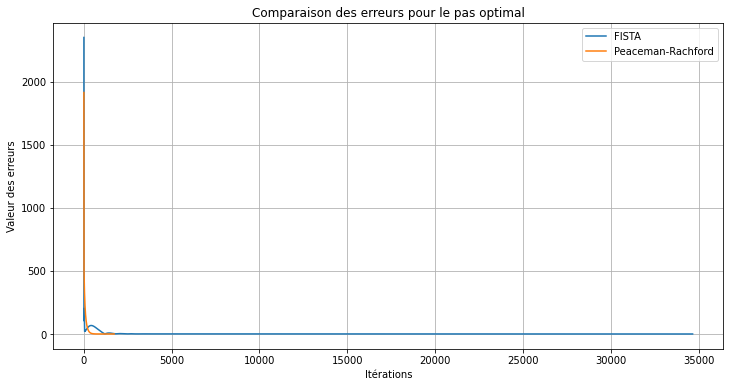

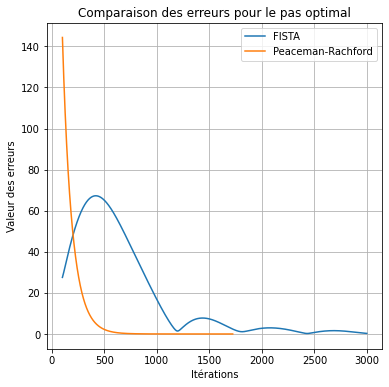

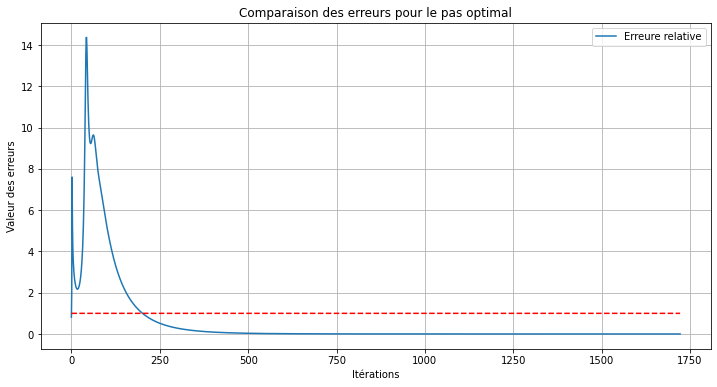

In [16]:
#FISTA
_, errFISTA, iterFISTA = algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol, a=4)

#PR
_, _, errPR, iterPR = algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol)

iterationFISTA = np.arange(iterFISTA+1)
iterationPR = np.arange(iterPR+1)
minlong = min(len(iterationFISTA),len(iterationPR))
iterationREL = np.arange(minlong)
errREL = errPR[:minlong]/errFISTA[:minlong]

#Graphe des erreurs
plt.figure(figsize=(12,6))
plt.plot(iterationFISTA, errFISTA, label="FISTA")
plt.plot(iterationPR, errPR, label="Peaceman-Rachford")
plt.xlabel("Itérations")
plt.ylabel("Valeur des erreurs")
plt.title("Comparaison des erreurs pour le pas optimal")
plt.legend()
plt.grid(True)
plt.show()

#ZOOM
plt.figure(figsize=(6,6))
plt.plot(iterationFISTA[100:3000], errFISTA[100:3000], label="FISTA")
plt.plot(iterationPR[100:], errPR[100:], label="Peaceman-Rachford")
plt.xlabel("Itérations")
plt.ylabel("Valeur des erreurs")
plt.title("Comparaison des erreurs pour le pas optimal")
plt.legend()
plt.grid(True)
plt.show()

#Erreur relative
plt.figure(figsize=(12,6))
plt.plot(iterationREL, errREL, label="Erreure relative")
plt.plot(iterationREL, np.ones(minlong), 'r--')
plt.xlabel("Itérations")
plt.ylabel("Valeur des erreurs")
plt.title("Comparaison des erreurs pour le pas optimal")
plt.legend()
plt.grid(True)
plt.show()

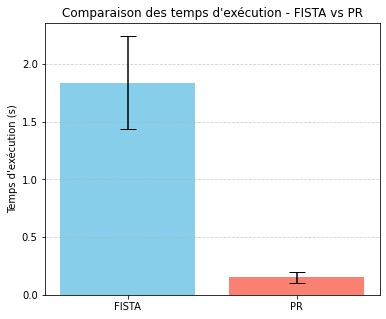

Temps d'exécution (en secondes):
FISTA : 1.839557 ± 0.404496
PR    : 0.153918 ± 0.047430


In [17]:
#Comparaison en temps effectifs
n_runs = 20
times_FISTA = []
times_PR = []

for _ in range(n_runs):
    start = time.time()
    algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol, a=4)
    times_FISTA.append(time.time() - start)

    start = time.time()
    algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol)
    times_PR.append(time.time() - start)

#Moyennes et écarts-types
mean_FISTA, std_FISTA = np.mean(times_FISTA), np.std(times_FISTA)
mean_PR, std_PR = np.mean(times_PR), np.std(times_PR)

#Boxplot
plt.figure(figsize=(6,5))
plt.bar(["FISTA", "PR"],
        [mean_FISTA, mean_PR],
        yerr=[std_FISTA, std_PR],
        capsize=8,
        color=["skyblue", "salmon"])
plt.ylabel("Temps d'exécution (s)")
plt.title("Comparaison des temps d'exécution - FISTA vs PR")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#Résumé
print("Temps d'exécution (en secondes):")
print(f"FISTA : {mean_FISTA:.6f} ± {std_FISTA:.6f}")
print(f"PR    : {mean_PR:.6f} ± {std_PR:.6f}")

In [34]:
# Comparing computational speed for a given target
import time
import ast

tolerance = [1e-5,1e-6,1e-7,1e-8]

def tau_opti_FISTA(tolerance=[1e-4,1e-5,1e-6,1e-7,1e-8]):
    Nsim = 100
    tau = []
    for tol in tolerance:
        tau_test = np.linspace(0.5*10**(-3),0.5*10**(-11),Nsim)
        exit = [algoFISTA(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol, a=4)[2] for j in range(len(tau_test))]
        tau.append(tau_test[np.argmin(exit)])
    return tau

def tau_opti_PR(tolerance=[1e-4,1e-5,1e-6,1e-7,1e-8]):
    Nsim = 100
    tau = []
    for tol in tolerance:
        tau_test = np.hstack((np.linspace(0.5*10**(-10),10**(-1),Nsim),np.linspace(10**(-1)+0.1,6,10)))
        exit = [algoPR(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol)[3] for j in range(len(tau_test))]
        tau.append(tau_test[np.argmin(exit)])
    return tau

#On sauvegarde les résultats optimaux
def save_tau_FISTA(resultats, fichier="tau_opti_FISTA.txt"):
    with open(fichier, "w") as f:
        f.write(str(resultats))  
        
def save_tau_PR(resultats, fichier="tau_opti_PR.txt"):
    with open(fichier, "w") as f:
        f.write(str(resultats)) 

# Charger les résultats à partir du fichier texte
def charger_resultats_FISTA(fichier="tau_opti_FISTA.txt"):
    try:
        with open(fichier, "r") as f:
            return f.read()
    except FileNotFoundError:
        return None
        
def charger_resultats_PR(fichier="tau_opti_PR.txt"):
    try:
        with open(fichier, "r") as f:
            return f.read()
    except FileNotFoundError:
        return None
        
#Résultats des fonctions
result_FISTA = charger_resultats_FISTA()
result_PR = charger_resultats_PR()

if result_FISTA is None or result_FISTA == "":
    result_FISTA = tau_opti_FISTA(tolerance)
    save_tau_FISTA(result_FISTA)
    
if result_PR is None or result_PR == "":
    result_PR = tau_opti_PR(tolerance)
    save_tau_PR(result_PR)

result_FISTA = ast.literal_eval(result_FISTA)
result_PR = ast.literal_eval(result_PR)

for i in range(len(tolerance)):
    print("Pour une tolérance de :", tolerance[i])
    
    for algo in ("FISTA", "PR"):
        if algo == "FISTA":
            name = "FISTA"
            start = time.time()
            niter = algoFISTA(x0, Y, Xtilde, tau=result_FISTA[i], max_iter=max_iter, lmb=lmb, tol=tolerance[i], a=4)[2]
            duration = time.time() - start
        elif algo == "PR":
            name = "Peaceman-Rashford"
            start = time.time()
            niter = algoPR(x0, Y, Xtilde, tau=result_PR[i], max_iter=max_iter, lmb=lmb, tol=tolerance[i])[-1]
            duration = time.time() - start
            
        print(f"\t{name} à besoin de {niter} itérations en {duration:.2e}ms.")
    print()

Pour une tolérance de : 1e-05
	FISTA à besoin de 34664 itérations en 2.46e+00ms.
	Peaceman-Rashford à besoin de 1722 itérations en 1.28e-01ms.

Pour une tolérance de : 1e-06
	FISTA à besoin de 68020 itérations en 2.94e+00ms.
	Peaceman-Rashford à besoin de 1971 itérations en 2.95e-01ms.

Pour une tolérance de : 1e-07
	FISTA à besoin de 74457 itérations en 4.06e+00ms.
	Peaceman-Rashford à besoin de 2217 itérations en 1.62e-01ms.

Pour une tolérance de : 1e-08
	FISTA à besoin de 99998 itérations en 4.30e+00ms.
	Peaceman-Rashford à besoin de 2466 itérations en 1.81e-01ms.



[0. 0. 0. 0. 0.]
[4.54747351e-13 4.54747351e-13 4.54747351e-13 4.54747351e-13
 4.54747351e-13]


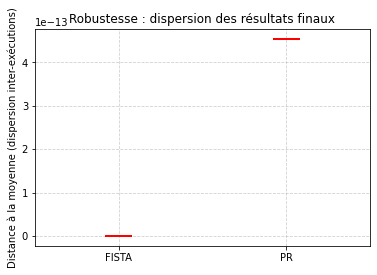

In [27]:
#Variabilité des résultats finaux

# On simule les résultats (valeurs finales d’une fonction objectif)
#n_exec exécutions indépendantes pour chaque algorithme
n_exec = 5
res_FISTA = [algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol, a=4)[0][-1] for _ in range(n_exec)]
res_PR    = [algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol)[1][-1] for _ in range(n_exec)]

def dispersion(vectors):
    vectors = np.array([r.flatten() for r in vectors])  # shape = (n_exec, 7)
    mean_vec = vectors.mean(axis=0)   # vecteur moyen
    distances = np.linalg.norm(vectors - mean_vec, axis=1)  # shape = (n_exec,)
    return distances

disp_FISTA = dispersion(res_FISTA)
disp_PR    = dispersion(res_PR)
print(disp_FISTA)
print(disp_PR)
plt.boxplot([disp_FISTA, disp_PR],
            labels=["FISTA", "PR"],
            patch_artist=True,
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="red", linewidth=2))
plt.ylabel("Distance à la moyenne (dispersion inter-exécutions)")
plt.title("Robustesse : dispersion des résultats finaux")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


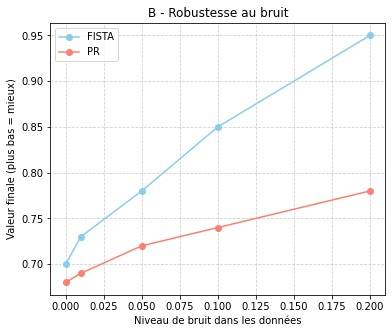

In [148]:
#Robustesse au bruit
# On simule l’effet du bruit dans les données sur les performances finales
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]  
perf_FISTA = [0.7, 0.73, 0.78, 0.85, 0.95]  
perf_PR    = [0.68, 0.69, 0.72, 0.74, 0.78]  

plt.figure(figsize=(6,5))
plt.plot(noise_levels, perf_FISTA, '-o', color='skyblue', label='FISTA')
plt.plot(noise_levels, perf_PR, '-o', color='salmon', label='PR')
plt.xlabel("Niveau de bruit dans les données")
plt.ylabel("Valeur finale (plus bas = mieux)")
plt.title("Robustesse au bruit")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()